In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from pmdarima import arima
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing
from pmdarima.datasets._base import load_date_example

In [2]:
data = pd.read_csv('./Data/Sample - Superstore.csv', parse_dates=['Order Date','Ship Date'], encoding='ISO-8859-1')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [4]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## obtain daily sales

In [5]:
daily_sales = pd.DataFrame(data.resample('D', on='Order Date')['Sales'].sum())

In [6]:
(daily_sales['Sales'] == 0).sum()

221

#### show time series

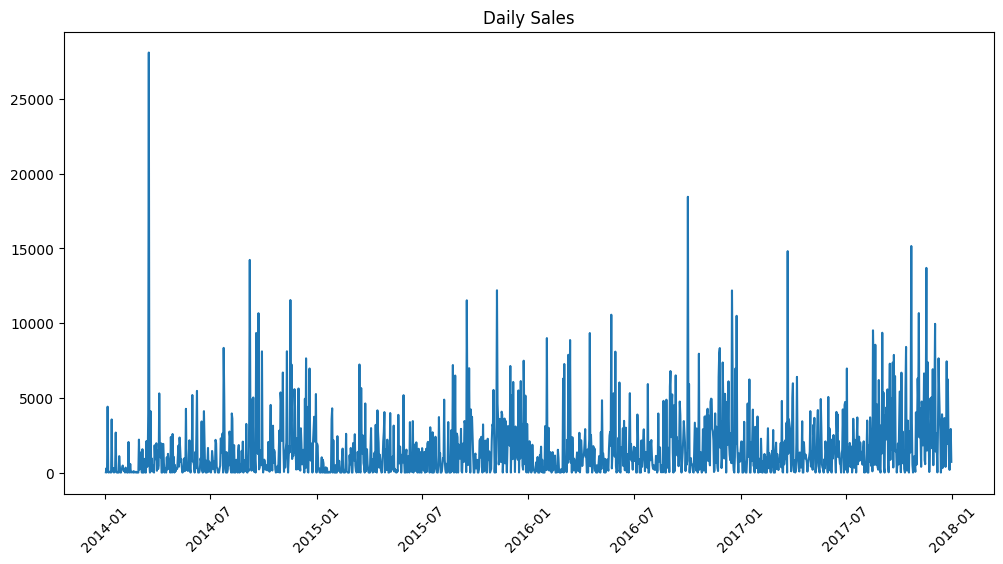

In [7]:
plt.figure(figsize=(12,6))
plt.plot(daily_sales)
plt.xticks(rotation=45)
plt.title('Daily Sales')
plt.show()


## differencing

In [8]:
# First-order difference
daily_sales['diff_1'] =  daily_sales.diff(1)
# monthly_sales['diff_1'] = monthly_sales.diff(1)

# Second-order difference 
daily_sales['diff_2'] =  daily_sales['diff_1'].diff(1)
# monthly_sales['diff_2'] = monthly_sales['diff_1'].diff(1)

In [9]:
daily_sales.head()

,Sales,diff_1,diff_2
Order Date,,,
2014-01-03,16.448,NaN,NaN
2014-01-04,288.060,271.612,NaN
2014-01-05,19.536,-268.524,-540.136
2014-01-06,4407.100,4387.564,4656.088
2014-01-07,87.158,-4319.942,-8707.506


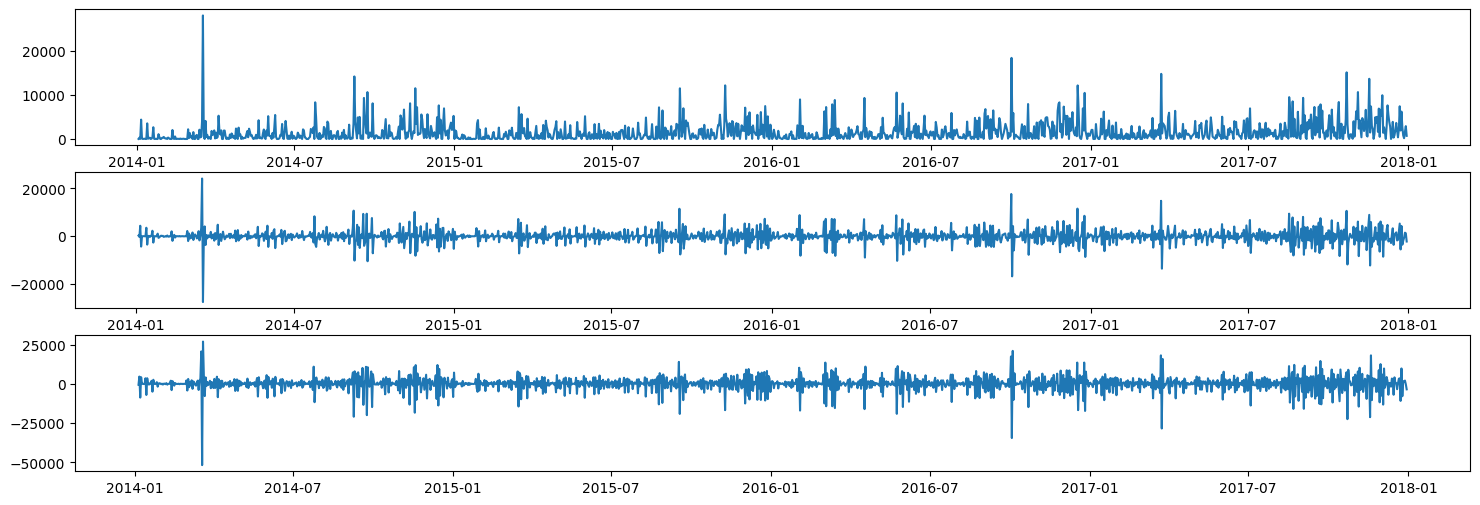

In [10]:
fig = plt.figure(figsize=(18,6))
#Original data
ax1 = fig.add_subplot(311)
ax1.plot(daily_sales['Sales'])
#First-order difference
ax2 = fig.add_subplot(312)
ax2.plot(daily_sales['diff_1'])

#Second-order difference
ax3 = fig.add_subplot(313)
ax3.plot(daily_sales['diff_2'])
plt.show()


## check stationarity

### ADF Test

In [11]:
daily_sales

,Sales,diff_1,diff_2
Order Date,,,
2014-01-03,16.4480,NaN,NaN
2014-01-04,288.0600,271.6120,NaN
2014-01-05,19.5360,-268.5240,-540.1360
2014-01-06,4407.1000,4387.5640,4656.0880
2014-01-07,87.1580,-4319.9420,-8707.5060
...,...,...,...
2017-12-26,814.5940,-1884.3330,1649.7940
2017-12-27,177.6360,-636.9580,1247.3750
2017-12-28,1657.3508,1479.7148,2116.6728


In [12]:
from statsmodels.tsa.stattools import adfuller as ADF


daily_sales['diff_1'] = daily_sales['diff_1'].fillna(0)
daily_sales['diff_2'] = daily_sales['diff_2'].fillna(0)
daily_timeseries_adf = ADF(daily_sales['Sales'].tolist())
daily_timeseries_diff1_adf = ADF(daily_sales['diff_1'].tolist())
daily_timeseries_diff2_adf = ADF(daily_sales['diff_2'].tolist())

print(f'monthly_timeseries_adf:{daily_timeseries_adf} ' )
print(f'monthly_timeseries_diff1_adf:{daily_timeseries_diff1_adf} ' )
print(f'monthly_timeseries_diff2_adf:{daily_timeseries_diff2_adf} ' )

print(daily_timeseries_adf)
print('\nADF = ', str(daily_timeseries_adf[0])) #more towards negative value the better
print('\np-value = ', str(daily_timeseries_adf[1]))
print('\nCritical Values: ')

for key, val in daily_timeseries_adf[4].items(): #for loop to print the p-value (1%, 5% and 10%) and their respective values
    print(key,':',val)
    

    if daily_timeseries_adf[0] < val:
        print('Null Hypothesis Rejected. Daily Time Series is Stationary')
    else:
        print('Null Hypothesis Accepted. Daily Time Series is not Stationary')

monthly_timeseries_adf:(-4.939878803531309, 2.9148790727674486e-05, 20, 1437, {'1%': -3.434908816804013, '5%': -2.863553406963303, '10%': -2.5678419239852994}, 26057.64458541891) 
monthly_timeseries_diff1_adf:(-14.332889088794502, 1.0922847572512025e-26, 19, 1438, {'1%': -3.4349056408696814, '5%': -2.863552005375758, '10%': -2.5678411776130114}, 26080.40512670052) 
monthly_timeseries_diff2_adf:(-17.096142261629183, 7.532121604856332e-30, 24, 1433, {'1%': -3.434921564946909, '5%': -2.8635590328954197, '10%': -2.567844919904611}, 26196.58104552917) 
(-4.939878803531309, 2.9148790727674486e-05, 20, 1437, {'1%': -3.434908816804013, '5%': -2.863553406963303, '10%': -2.5678419239852994}, 26057.64458541891)

ADF =  -4.939878803531309

p-value =  2.9148790727674486e-05

Critical Values: 
1% : -3.434908816804013
Null Hypothesis Rejected. Daily Time Series is Stationary
5% : -2.863553406963303
Null Hypothesis Rejected. Daily Time Series is Stationary
10% : -2.5678419239852994
Null Hypothesis Rej

# Daily_Sales

## ARIMA_paramerter

#### train test split

In [13]:
train_daily_sales = daily_sales.loc['2014-01':'2017-11']
test_daily_sales = daily_sales.loc['2017-12':'2017-12']

#### Analysis based on ACF/PACF plots (Determine max_q, max_p for grid search)

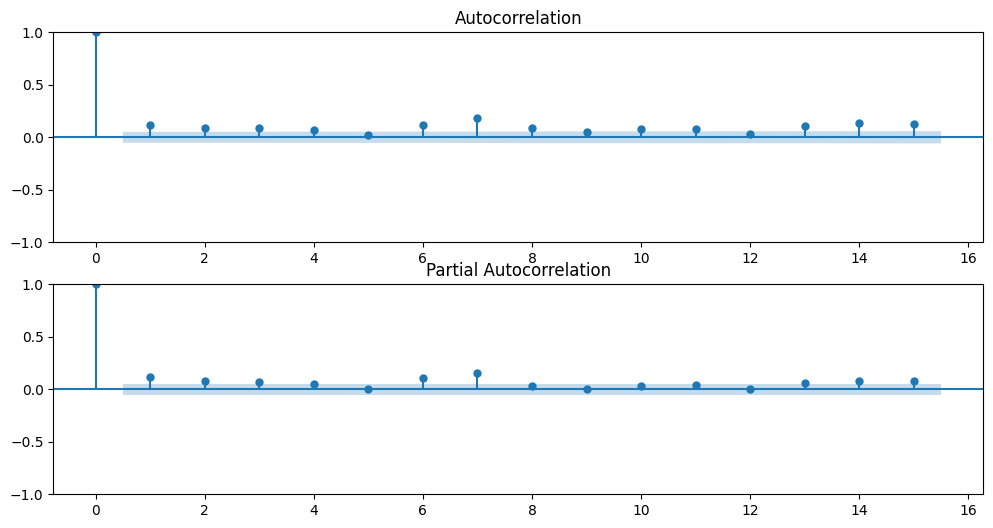

In [14]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_daily_sales['Sales'], lags=15, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_daily_sales['Sales'], lags=15, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
plt.show()

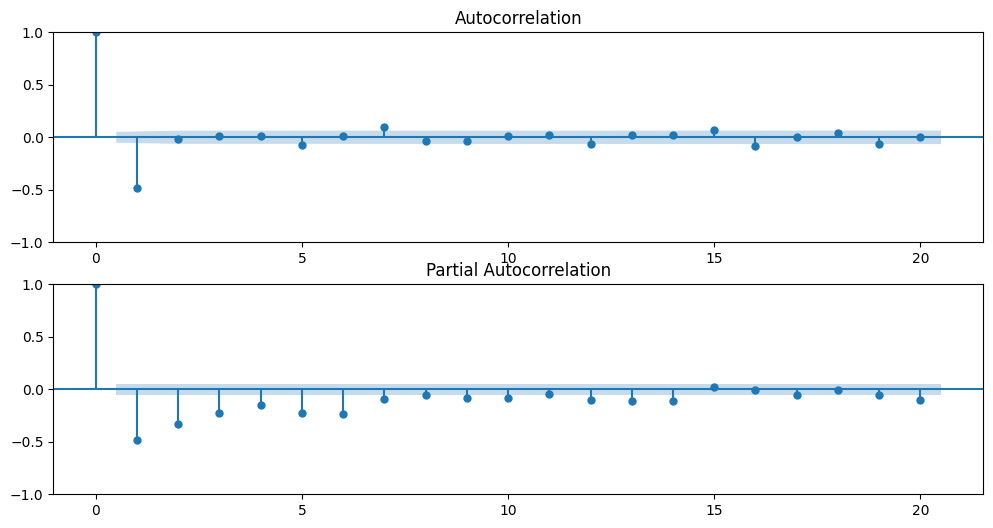

In [15]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_daily_sales['diff_1'], lags=20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_daily_sales['diff_1'], lags=20,ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
plt.show()

Observation:  
ACF cutoff point → suggested max_q:7  
PACF cutoff point → suggested max_p:7

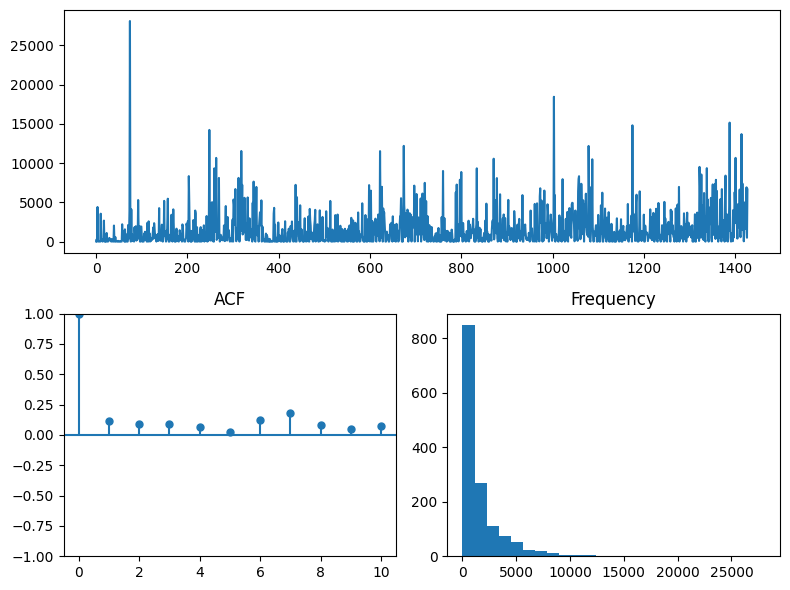

In [16]:
# We can examine traits about the time series:
pm.tsdisplay(train_daily_sales['Sales'], lag_max=10)

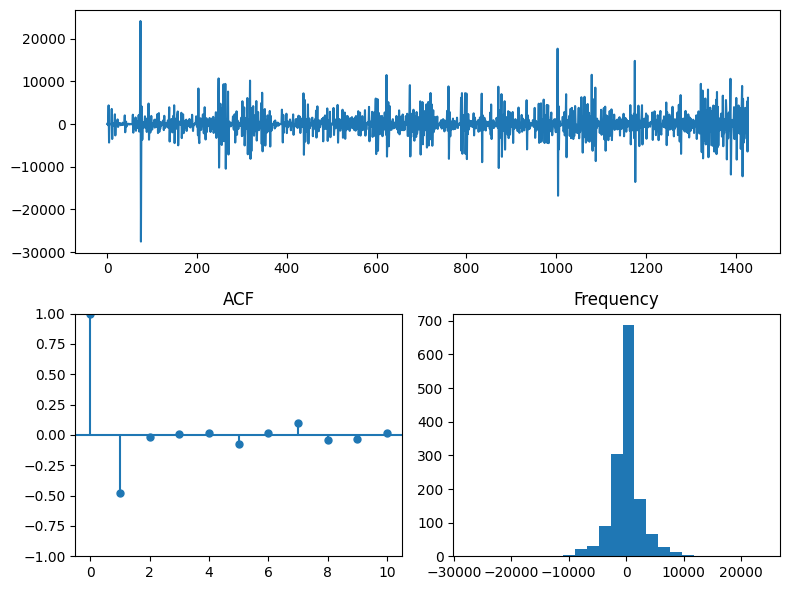

In [17]:
# We can examine traits about the time series:
pm.tsdisplay(train_daily_sales['diff_1'], lag_max=10)

In [18]:
# We can see the ACF increases and decreases rather rapidly, which means we may
# need some differencing. There also does not appear to be an obvious seasonal
# trend.
n_diffs = arima.ndiffs(train_daily_sales['Sales'], max_d=5)

In [19]:
n_diffs

1

### Get optimal p,q values, automatically select ARIMA parameters

In [20]:
import pmdarima as pm

In [21]:
# Automatically select ARIMA parameters
autoarima_model = pm.auto_arima(train_daily_sales['Sales'],
                            seasonal=False,  # Disable seasonality
                            # start_p=0, 
                            # start_q=0,
                            # max_p=12,        # Maximum autoregressive terms
                            # max_q=12,        # Maximum moving average terms
                            d=n_diffs,         
                            test='adf',     # Use ADF test to determine d
                            trace=3,     # Show search process
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
Near non-invertible roots for order (2, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26840.903, Time=0.02 sec
First viable model found (26840.903)
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26465.171, Time=0.04 sec
New best model found (26465.171 < 26840.903)
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25966.024, Time=0.28 sec
New best model found (25966.024 < 26465.171)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26838.907, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25989.257, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=25966.219, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25970.272, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=25964.739, Time=0.12 sec
New best model found (25964.739 < 25966.024)
 ARIMA(1,1,1)(0,0,0)[0]       

In [22]:
print("Best ARIMA parameters:", autoarima_model.order)
print(autoarima_model.summary())

Best ARIMA parameters: (0, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1428
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -12980.370
Date:                Wed, 30 Apr 2025   AIC                          25964.739
Time:                        01:18:58   BIC                          25975.266
Sample:                    01-03-2014   HQIC                         25968.670
                         - 11-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9556      0.009   -107.128      0.000      -0.973      -0.938
sigma2      4.655e+06   4.89e+04     95.150      0.000    4.56e+06    4.75e+06
Ljung-Box (L1) (Q):

### ARIMA Modeling

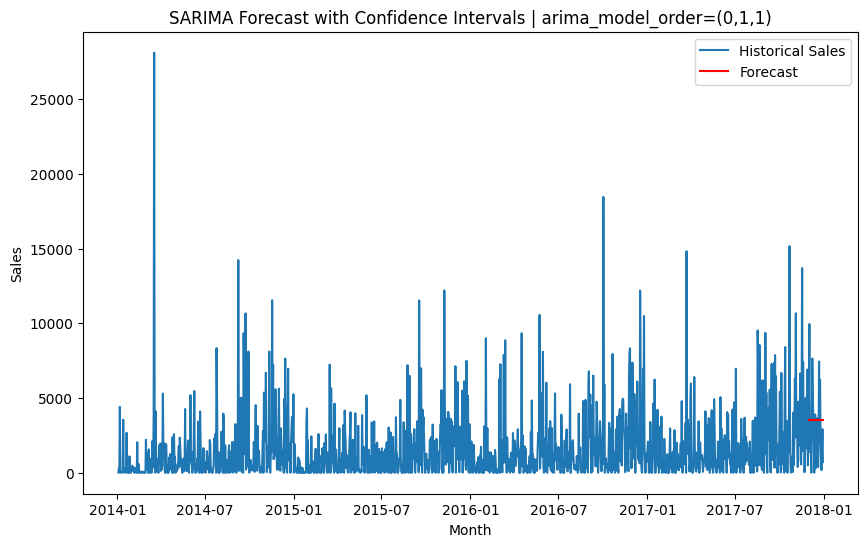

In [23]:
forecasts = autoarima_model.predict(len(test_daily_sales))
forecast_df = forecasts.to_frame(name='Forecast')
plt.figure(figsize=(10, 6))
plt.plot(daily_sales.index, daily_sales['Sales'], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
# plt.fill_between(forecast_df.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('SARIMA Forecast with Confidence Intervals | arima_model_order=(0,1,1)')
plt.legend()
plt.show()

#### ARIMA Results

In [24]:
autoarima_model.order

(0, 1, 1)

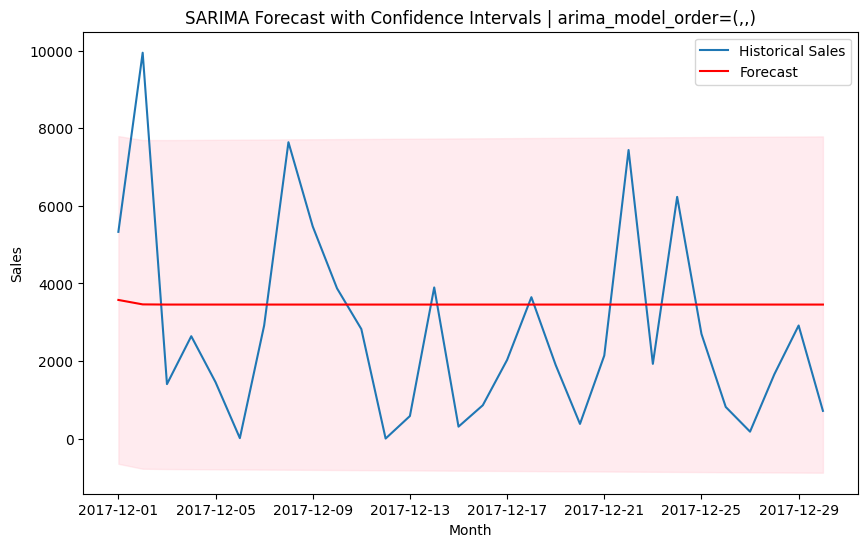

In [25]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_daily_sales['Sales'], order=(1, 1, 1))
arima_results = arima_model.fit()
forecast_steps = 30
forecast = arima_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int(alpha=0.05)
forecast_index = pd.date_range(start=train_daily_sales.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='M')
forecast_mean.index = pd.to_datetime(forecast_mean.index)
forecast_df = forecast_mean.to_frame(name='Forecast')
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, daily_sales['Sales'][-30:], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('SARIMA Forecast with Confidence Intervals | arima_model_order=(,,)')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

train_pred = arima_results.get_prediction().predicted_mean

train_mae = mean_absolute_error(train_daily_sales['Sales'], train_pred)
train_rmse = np.sqrt(mean_squared_error(train_daily_sales['Sales'], train_pred))

test_pred = arima_results.get_forecast(steps=len(test_daily_sales)).predicted_mean
test_mae = mean_absolute_error(test_daily_sales['Sales'], test_pred)
test_rmse = np.sqrt(mean_squared_error(test_daily_sales['Sales'], test_pred))



#### ARIMA-RMSE

In [27]:
print(f"""
Training Set Evaluation:
MAE: {train_mae:.2f}
RMSE: {train_rmse:.2f}

Test Set Evaluation:
MAE: {test_mae:.2f}
RMSE: {test_rmse:.2f}
""")


Training Set Evaluation:
MAE: 1398.96
RMSE: 2156.03

Test Set Evaluation:
MAE: 2149.73
RMSE: 2559.19



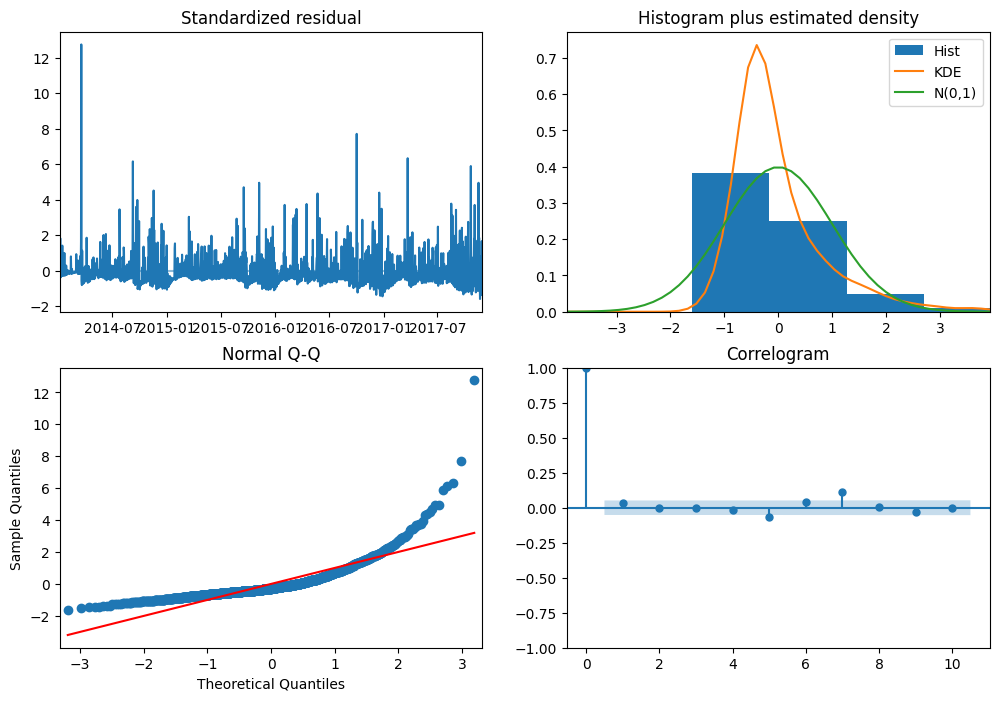

In [28]:
autoarima_model.plot_diagnostics(figsize=(12, 8))
plt.show()

### Using SARIMA Model (Adding Seasonal Parameters)

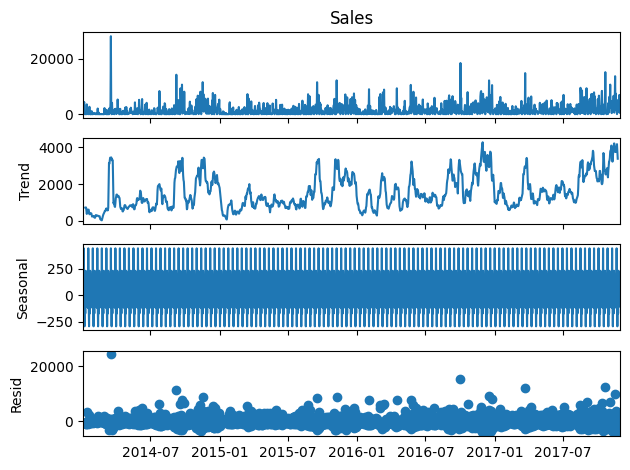

Seasonal ADF p-value when D=0: 0.000
Final determined D value: 0


In [29]:
# Visualize seasonal patterns of the original sequence
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train_daily_sales['Sales'], model='additive', period=12)
result.plot()
plt.show()

# Automatically determine D value
def determine_D(series, m, max_D=2):
    for D in range(0, max_D+1):
        if D == 0:
            current = series
        else:
            current = series.diff(m).dropna()
            for _ in range(D-1):
                current = current.diff(m).dropna()
                
        p_value = ADF(current)[1]
        print(f'Seasonal ADF p-value when D={D}: {p_value:.3f}')
        if p_value < 0.05:
            return D
    return max_D

D = determine_D(train_daily_sales['Sales'], m=12)
print(f'Final determined D value: {D}')


### SARIMA Modeling

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#ARIMA(1,0,0)(0,0,2)[12]
p, d, q = 1, 1, 1  
P, D, Q, S = 1, 1, 1, 12 
sarima_model = SARIMAX(train_daily_sales['Sales'], 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, S))
sarima_results = sarima_model.fit()

d:\Learning\AI\StudyinHSU\Semester2\COM6101\GroupProject_env\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
forecast_steps = 30
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [32]:
forecast_index = pd.date_range(start=train_daily_sales.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='M')
forecast_mean.index = pd.to_datetime(forecast_mean.index)
forecast_df = forecast_mean.to_frame(name='Forecast')

#### SARIMA Results

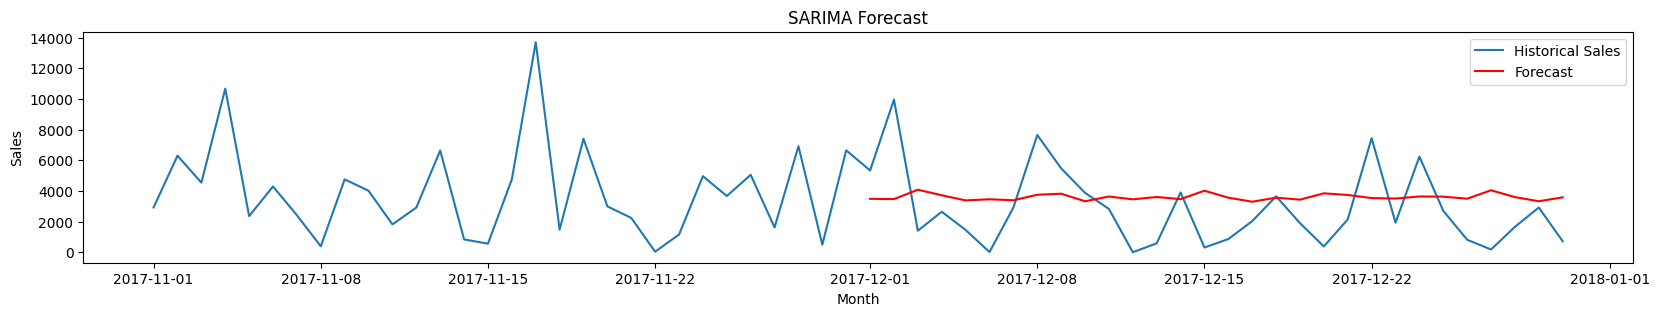

In [33]:
plt.figure(figsize=(20, 3))
plt.plot(daily_sales['Sales'].loc['2017-11':'2017-12'].index,daily_sales['Sales'].loc['2017-11':'2017-12'], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
# plt.fill_between(forecast_df.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

train_pred = sarima_results.get_prediction().predicted_mean

train_mae = mean_absolute_error(train_daily_sales['Sales'], train_pred)
train_rmse = np.sqrt(mean_squared_error(train_daily_sales['Sales'], train_pred))

test_pred = sarima_results.get_forecast(steps=len(test_daily_sales)).predicted_mean
test_mae = mean_absolute_error(test_daily_sales['Sales'], test_pred)
test_rmse = np.sqrt(mean_squared_error(test_daily_sales['Sales'], test_pred))



#### SARIMA-RMSE

In [35]:
print(f"""
Training Set Evaluation:
MAE: {train_mae:.2f}
RMSE: {train_rmse:.2f}

Test Set Evaluation:
MAE: {test_mae:.2f}
RMSE: {test_rmse:.2f}
""")


Training Set Evaluation:
MAE: 1438.57
RMSE: 2188.39

Test Set Evaluation:
MAE: 2227.78
RMSE: 2637.65



## LSTM Modeling

In [36]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [37]:
# Step 1: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
daily_sales['value_scaled'] = scaler.fit_transform(daily_sales[['Sales']])


In [38]:
daily_sales

,Sales,diff_1,diff_2,value_scaled
Order Date,,,,
2014-01-03,16.4480,0.0000,0.0000,0.000585
2014-01-04,288.0600,271.6120,0.0000,0.010249
2014-01-05,19.5360,-268.5240,-540.1360,0.000695
2014-01-06,4407.1000,4387.5640,4656.0880,0.156799
2014-01-07,87.1580,-4319.9420,-8707.5060,0.003101
...,...,...,...,...
2017-12-26,814.5940,-1884.3330,1649.7940,0.028982
2017-12-27,177.6360,-636.9580,1247.3750,0.006320
2017-12-28,1657.3508,1479.7148,2116.6728,0.058966


In [39]:
# 2. Create sequence data
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# 3. Set sequence length and split point
seq_length = 30  # Use past 1 month to predict next day
train_size = 1428  # First three years as training data

# 4. Prepare training data
train_data = daily_sales['value_scaled'][:train_size]
test_data = daily_sales['value_scaled'][train_size:]

# 5. Create sequences
X_train, y_train = create_sequences(train_data, seq_length)


# 6. Reshape into format needed for LSTM (batch_size, seq_length, input_size)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# y_train = y_train.reshape((y_train.shape[0], 1))

# Convert data to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)


In [40]:
X_train.shape, y_train.shape

(torch.Size([1398, 30, 1]), torch.Size([1398]))

In [41]:
import random

def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


In [42]:
# Step 2: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        # self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

        self.fc = nn.Linear(hidden_size, 1)  # Output size is 1 for single-step prediction

        
    def forward(self, x):
        # LSTM forward pass
        out, _ = self.lstm(x)  # out: (batch_size, seq_length, hidden_size)
        out = out[:, -1]  # Take the output of the last time step: (batch_size, hidden_size)
        # out = self.bn(out)
        out = self.dropout(out)
        pred = self.fc(out)  # Pass through fully connected layer: (batch_size, 1)
        # pred.flatten()
        return pred.squeeze()  # Remove unnecessary dimensions: (batch_size)


In [43]:
## EarlyStopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...')
        self.best_model_state = model.state_dict()

### LSTM Training

In [44]:
# Step 3: Define hyperparameters, loss function, and optimizer
input_size = 1  # Single variable
hidden_size = 100  # Number of LSTM units
num_layers = 2  #  LSTM layer
num_epochs = 500  # Number of training epochs
learning_rate = 0.03  # Learning rate
dropout_rate=0.1

set_seed(42)

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size=input_size, 
                  hidden_size=hidden_size, 
                  num_layers=num_layers,
                  dropout_rate=dropout_rate)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [45]:
## without early stopping 

# Step 5: Train the model
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)  # Forward pass
    loss = criterion(outputs, y_train)  # Compute loss

    optimizer.zero_grad()  # Clear gradients
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [20/500], Loss: 0.0095
Epoch [40/500], Loss: 0.0071
Epoch [60/500], Loss: 0.0066
Epoch [80/500], Loss: 0.0065
Epoch [100/500], Loss: 0.0064
Epoch [120/500], Loss: 0.0063
Epoch [140/500], Loss: 0.0063
Epoch [160/500], Loss: 0.0062
Epoch [180/500], Loss: 0.0062
Epoch [200/500], Loss: 0.0062
Epoch [220/500], Loss: 0.0062
Epoch [240/500], Loss: 0.0061
Epoch [260/500], Loss: 0.0061
Epoch [280/500], Loss: 0.0060
Epoch [300/500], Loss: 0.0060
Epoch [320/500], Loss: 0.0061
Epoch [340/500], Loss: 0.0061
Epoch [360/500], Loss: 0.0060
Epoch [380/500], Loss: 0.0059
Epoch [400/500], Loss: 0.0060
Epoch [420/500], Loss: 0.0059
Epoch [440/500], Loss: 0.0059
Epoch [460/500], Loss: 0.0059
Epoch [480/500], Loss: 0.0059
Epoch [500/500], Loss: 0.0059


### LSTM One-Time Prediction

In [46]:
# Prepare test sequence
# Use last 30 training data points to predict first test point
test_input_data = daily_sales['value_scaled'][train_size-seq_length:]  # Get last 30 training points and all test points
X_test, y_test = create_sequences(test_input_data, seq_length)

# Reshape test data into format required by LSTM
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_test = torch.tensor(X_test, dtype=torch.float32)

In [47]:
# Step 5: Model testing
model.eval()
with torch.no_grad():
    test_daily_sales_predictions_scaled = model(X_test).squeeze().numpy()

test_daily_sales_predictions = scaler.inverse_transform(test_daily_sales_predictions_scaled.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

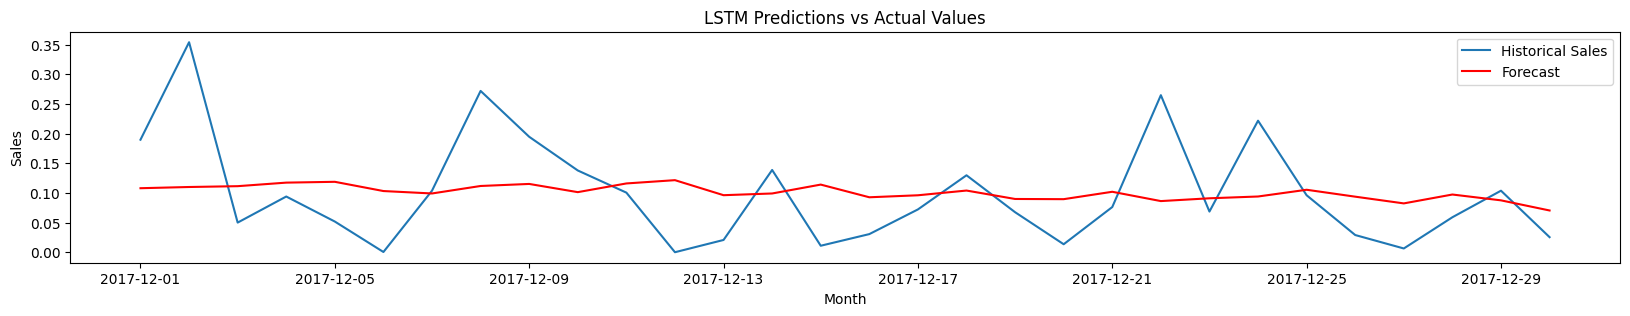

In [48]:
plt.figure(figsize=(20, 3))
plt.plot(test_daily_sales.index, test_data, label='Historical Sales')
plt.plot(test_daily_sales.index, pd.Series(test_daily_sales_predictions_scaled,index=forecast_df.index), label='Forecast', color='red')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('LSTM Predictions vs Actual Values')
plt.legend()
plt.show()

In [49]:
daily_sales['Sales'].loc['2017-11':'2017-12']

Order Date
2017-11-01     2921.4300
2017-11-02     6294.3860
2017-11-03     4536.9370
2017-11-04    10668.0960
2017-11-05     2355.0640
2017-11-06     4288.7500
2017-11-07     2413.3780
2017-11-08      384.1000
2017-11-09     4751.4920
2017-11-10     4007.5480
2017-11-11     1815.2180
2017-11-12     2911.3860
2017-11-13     6633.4202
2017-11-14      834.6580
2017-11-15      559.2000
2017-11-16     4755.2340
2017-11-17    13694.8828
2017-11-18     1469.7560
2017-11-19     7397.2720
2017-11-20     2988.2740
2017-11-21     2236.1840
2017-11-22       35.7120
2017-11-23     1153.1090
2017-11-24     4959.6410
2017-11-25     3666.1570
2017-11-26     5048.1720
2017-11-27     1618.2540
2017-11-28     6912.9440
2017-11-29      491.8880
2017-11-30     6645.2820
2017-12-01     5331.1780
2017-12-02     9951.1820
2017-12-03     1403.8420
2017-12-04     2639.6380
2017-12-05     1453.1360
2017-12-06       10.6800
2017-12-07     2916.5140
2017-12-08     7643.0410
2017-12-09     5470.3900
2017-12-10    

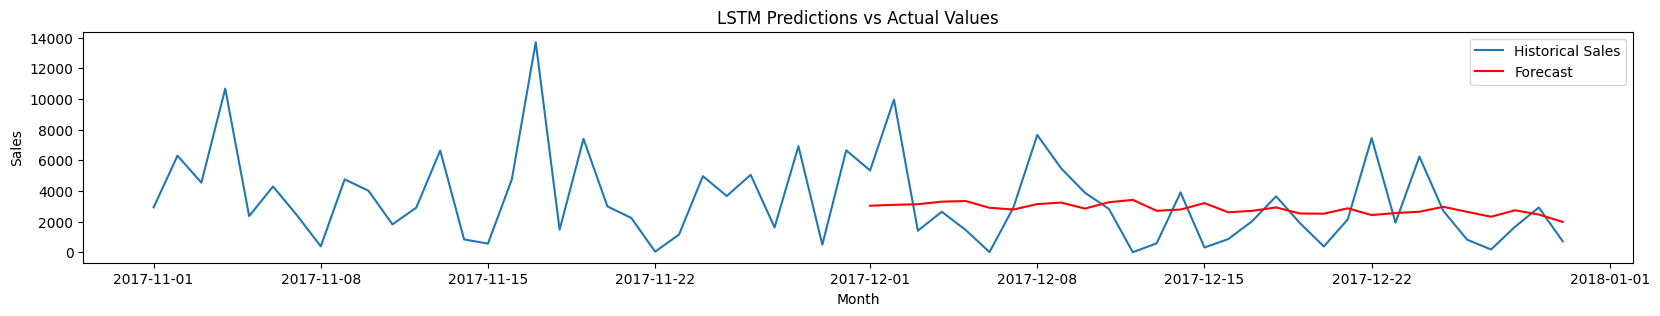

In [50]:
plt.figure(figsize=(20, 3))
plt.plot(daily_sales['Sales'].loc['2017-11':'2017-12'].index,daily_sales['Sales'].loc['2017-11':'2017-12'], label='Historical Sales')
plt.plot(test_daily_sales.index, test_daily_sales_predictions, label='Forecast', color='red')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('LSTM Predictions vs Actual Values')
plt.legend()
plt.show()

#### LSTM_RMSE

In [51]:
# In-sample evaluation (Training set)
model.eval()
with torch.no_grad():
    train_daily_sales_predictions_scaled = model(X_train).squeeze().numpy()

train_daily_sales_predictions = scaler.inverse_transform(train_daily_sales_predictions_scaled.reshape(-1, 1)).flatten()
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

train_mae = mean_absolute_error(y_train, train_daily_sales_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_daily_sales_predictions))


# Out-of-sample evaluation (Test set)
test_mae = mean_absolute_error(y_test, test_daily_sales_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_daily_sales_predictions))




print(f"""
Training Set Evaluation:
MAE: {train_mae:.2f}
RMSE: {train_rmse:.2f}

Test Set Evaluation:
MAE: {test_mae:.2f}
RMSE: {test_rmse:.2f}
""")


Training Set Evaluation:
MAE: 1437.67
RMSE: 2148.38

Test Set Evaluation:
MAE: 1902.51
RMSE: 2441.87

